In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device = {device}')

Device = cuda


In order to deal with equations in an unbounded domain, some kind of artificial boundary conditions are proposed to mitigate the influence of spurious reflections at these boundaries which occur in the simulations of wave propagation phenomenawe. The 1d scalar wave euqation with Mur ABC (Absorbing Boudary Condition) has the following form,:
\begin{equation}
\begin{split}
&u_{tt} - c^2u_{xx} = f(x, t), 0 < x < L, 0 < t < T\\
&u_t(0, t) - cu_x(0, t) = 0\\
&u_t(L, t) + cu_x(L, t) = 0\\
&u(x, 0) = 0\\
&u_t(x, 0)  = 0 
\end{split}
\end{equation}
We can solve it with FDTD (Finite Difference Time Domain) method.

In [2]:
from fdsolver import FDTD1D
c = np.ones(201) * 2
nx = 200
h = 0.01
dt = 0.003
nt = 300
x0 = 100
f0 = 10
solver = FDTD1D(h, dt, c, nt, x0, f0)
solver.cfl_number()
L = h * nx 
T = dt * nt

CFL number is 0.6, number of grid points in each wavelength is about 20


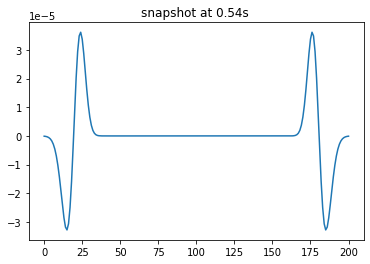

In [3]:
solver.steps()
solver.plot_wavefield_nt(180)

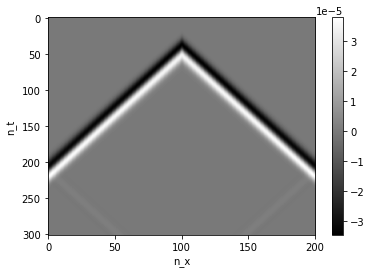

In [4]:
solver.plot_wavefield()

In [5]:
solver.wavefield.shape

(301, 201)

In [6]:
# Solution 
t_star = np.arange(nt+1) * dt
x_star = np.arange(nx+1) * h
X, T = np.meshgrid(x_star, t_star)
t_star = T.flatten()[:, np.newaxis]
x_star = X.flatten()[:, np.newaxis]
u_star = solver.wavefield.flatten()[:, np.newaxis]

In [7]:
def ricker(t, f0):
    """Ricker wavelet
    """
    sigma = 1 / (np.pi * f0 * np.sqrt(2))
    t0 = 6 * sigma
    tmp = np.pi**2 * f0**2 * (t-t0)**2 
    w = (1 - 2*tmp) * np.exp(-tmp)
    return w

def delta(x, x0, beta):
    exp = np.exp(-(x-x0)**2 / beta)
    return exp / np.sqrt(np.pi * beta)

In [8]:
class DNN(nn.Module):
    """Fully connected neural network
    """
    def __init__(self, layer_sizes):
        super(DNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

    def forward(self, x):
        for linear in self.linears[:-1]:
            # x = torch.nn.functional.softplus(linear(x))
            # x = torch.sigmoid(linear(x))
            # x = torch.nn.functional.relu(linear(x))
            # x = torch.tanh(linear(x))
            x = torch.sin(linear(x))
        x = self.linears[-1](x)
        return x 

In [9]:
class PINN(nn.Module):
    """Physic informed neural network
    """
    def __init__(self, c, x0, f0, beta, layer_sizes, Ni, Nb, Nc):
        super(PINN, self).__init__()
        self.c = c
        self.x0 = x0
        self.f0 = f0
        self.beta = beta
        
        # Initial condition
        xi = np.random.uniform(0, 2, (Ni, 1))
        self.xi = torch.tensor(xi, dtype=torch.float32, requires_grad=True, device=device)
        self.ti = torch.zeros(Ni, 1, dtype=torch.float32, requires_grad=True, device=device)
    
        # Boundary condition
        tl = np.random.uniform(0, 1, (Nb, 1))
        xl = np.zeros((Nb, 1))
        self.tl = torch.tensor(tl, dtype=torch.float32, requires_grad=True, device=device)
        self.xl = torch.tensor(xl, dtype=torch.float32, requires_grad=True, device=device)
        tr = np.random.uniform(0, 1, (Nb, 1))
        xr = np.ones((Nb, 1)) * 2  
        self.tr = torch.tensor(tr, dtype=torch.float32, requires_grad=True, device=device)
        self.xr = torch.tensor(xr, dtype=torch.float32, requires_grad=True, device=device)        
        
        # Collocation points
        xf = np.random.uniform(0, 2, (Nc, 1))
        tf = np.random.uniform(0, 1, (Nc, 1))
        f = ricker(tf, self.f0) * delta(xf, self.x0, self.beta) #* 1e4 # Be careful !!!
        self.xf = torch.tensor(xf, dtype=torch.float32, requires_grad=True, device=device)
        self.tf = torch.tensor(tf, dtype=torch.float32, requires_grad=True, device=device)
        self.f = torch.tensor(f, dtype=torch.float32, requires_grad=True, device=device)
        
        self.error = []
        self.loss = []
        self.dnn = DNN(layer_sizes).to(device)
        self.iter = 0
        self.max_num_iter = 10000
        self.lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.adam = torch.optim.Adam(
            self.dnn.parameters(), 
            lr=0.01, 
        )
        
    def net_u(self, x, t):
        u = self.dnn(torch.cat((x, t), dim=1))
        return u 

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        Lu = u_tt  - self.c ** 2 * u_xx
        return Lu

    def compute_error(self):
        self.dnn.eval()
        u_pred, _ = self.predict(x_star, t_star)
        error = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
        self.error.append(error)
        self.dnn.train()

    def loss_func(self):
        self.compute_error()
        self.adam.zero_grad()
        # self.lbfgs.zero_grad()
        
        # Initial loss
        ui = self.net_u(self.xi, self.ti)
        ui_t = torch.autograd.grad(
            ui, self.ti,
            grad_outputs=torch.ones_like(ui),
            retain_graph=True,
            create_graph=True
        )[0]
        loss_i = torch.mean(ui** 2) + torch.mean(ui_t ** 2)
        
        # Collocation loss
        f_pred = self.net_f(self.xf, self.tf)
        loss_f = torch.mean((f_pred - self.f) ** 2)
        
        # Boundary loss
        ul = self.net_u(self.xl, self.tl)
        ul_t = torch.autograd.grad(
            ul, self.tl,
            grad_outputs=torch.ones_like(ul),
            retain_graph=True,
            create_graph=True
        )[0]
        ul_x = torch.autograd.grad(
            ul, self.xl,
            grad_outputs=torch.ones_like(ul),
            retain_graph=True,
            create_graph=True
        )[0]
        ur = self.net_u(self.xr, self.tr)
        ur_t = torch.autograd.grad(
            ur, self.tr,
            grad_outputs=torch.ones_like(ur),
            retain_graph=True,
            create_graph=True
        )[0]
        ur_x = torch.autograd.grad(
            ur, self.xr,
            grad_outputs=torch.ones_like(ur),
            retain_graph=True,
            create_graph=True
        )[0]
        loss_b = torch.mean((ul_t - self.c * ul_x) ** 2) + torch.mean((ur_t + self.c * ur_x) ** 2)

        # loss = loss_i + loss_b +  loss_f
        loss = loss_f
        self.loss.append(loss.item())
        
        loss.backward()

        if self.iter % 500 == 0:
            print("Iter %d, Loss: %.4e, Initial loss: %.4e, Boundary loss: %.4e, Collocation loss : %.4e" 
                  % (self.iter, loss.item(), loss_i.item(), loss_b.item(), loss_f.item()))
        self.iter += 1
        return loss
    
    # def compute_loss(self):
    #     self.optimizer.zero_grad()
    #     li = self.initial_loss()
    #     lb = self.boundary_loss()
    #     lc = self.collocation_loss()
    #     l = li + lb + lc 
    #     l.backward()
    #     self.loss.append(l.item())
    #     self.num_iter += 1
    #     if self.num_iter % 500 == 0 or self.num_iter == self.max_num_iter:
    #         self.loss.append(l.item())
    #         print("Iter %d, Loss: %.4e, Initial loss: %.4e, Boundary loss: %.4e, Collocation loss : %.4e" 
    #               % (self.num_iter, l.item(), li.item(), lb.item(), lc.item()))
    #     return l

    def train(self):
        self.dnn.train()
        # self.lbfgs.step(self.loss_func)
        while self.iter < self.max_num_iter:
             self.adam.step(self.loss_func)

            
    def predict(self, x, t):
        self.dnn.eval() 
        x = torch.tensor(x, requires_grad=True, dtype=torch.float32, device=device)
        t = torch.tensor(t, requires_grad=True, dtype=torch.float32, device=device)
        u = self.net_u(x, t)
        Lu = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        Lu = Lu.detach().cpu().numpy()
        return u, Lu

In [10]:
Ni = 200
Nb = 200
Nc = 10000
layer_sizes = [2] + [20] * 5 + [1]
c = 2
x0 = 1.
f0 = 10.
beta = 0.01
Ni = 500
Nb = 500
Nc = 10000
model = PINN(c, x0, f0, beta, layer_sizes, Ni, Nb, Nc)

In [11]:
model.train()

Iter 0, Loss: 6.3909e-02, Initial loss: 3.3026e-02, Boundary loss: 9.7803e-04, Collocation loss : 6.3909e-02
Iter 500, Loss: 6.3463e-02, Initial loss: 8.3061e-05, Boundary loss: 3.9984e-05, Collocation loss : 6.3463e-02
Iter 1000, Loss: 5.8905e-02, Initial loss: 3.6339e-02, Boundary loss: 1.0271e-04, Collocation loss : 5.8905e-02
Iter 1500, Loss: 5.5430e-02, Initial loss: 1.0073e-01, Boundary loss: 3.1949e-04, Collocation loss : 5.5430e-02
Iter 2000, Loss: 5.3254e-02, Initial loss: 3.9764e-02, Boundary loss: 1.7441e-05, Collocation loss : 5.3254e-02
Iter 2500, Loss: 4.8094e-02, Initial loss: 1.8426e-01, Boundary loss: 1.1406e-04, Collocation loss : 4.8094e-02
Iter 3000, Loss: 6.2735e-02, Initial loss: 1.3673e-01, Boundary loss: 5.3349e-04, Collocation loss : 6.2735e-02
Iter 3500, Loss: 5.9524e-02, Initial loss: 4.1147e-01, Boundary loss: 5.0724e-04, Collocation loss : 5.9524e-02
Iter 4000, Loss: 5.8168e-02, Initial loss: 7.3399e-04, Boundary loss: 1.0154e-04, Collocation loss : 5.8168e

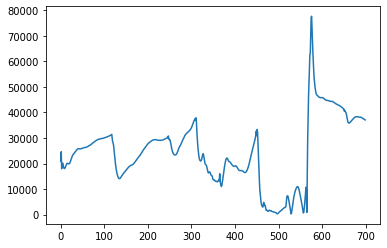

In [16]:
plt.plot(model.error[:700])

In [17]:
min(model.error[1000:])

56.065683984902414

In [14]:
model.error[0]

18813.50164443296

In [17]:
model.f.min(), model.f.max()
# normalization
# curriculum learning

(tensor(-2.4653, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(5.2553, device='cuda:0', grad_fn=<MaxBackward1>))

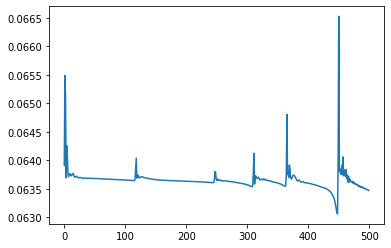

In [19]:
plt.plot(model.loss[:500])